In [14]:
if "running_all" not in globals():
    from ipywidgets import widgets
    matrices = ["ex10", "msc04515", "s1rmq4m1", "Na5", "bcsstk18",
                "vibrobox", "cbuckle", "Pres_Poisson", "raefsky4", "vanbody",
                "ct20stif", "cant", "bcircuit", "apache1", "consph"]
    b = widgets.Button(description="Run over all matrices", button_style="success")
    output = widgets.Output()

    display(b, output)

    def run_over_all_matrices(button):
        global running_all
        global matrix
        running_all = True
        with output:
            for matrix in matrices:
                print(f"Running {matrix}...")
                %run ./model_overhead_comparison.ipynb # will output at this cell rather than later
            print("Finished!")
    b.on_click(run_over_all_matrices)

Button(button_style='success', description='Run over all matrices', style=ButtonStyle())

Output()

In [15]:
if "running_all" not in globals():
    matrix = "cant"  # manually set to run over one matrix
matrix

'cant'

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
import os
from joblib import load
from json import load as json_load
from glob import glob
sys.path.append(os.path.join(os.getcwd(), os.pardir))
from io_utils import load_matrices_from_dir

In [17]:
ylims = {
    "apache1": (0, 0.25),
    "bcircuit": (0, 0.8),
    "bcsstk18": (0.2, 1.5),
    "cant": (0.6, 1.3),
    "cbuckle": (0, 1.0),
    "consph": (0, 0.02),
    "ct20stif": (0, 1.5),
    "ex10": (0.4, 1.5),
    "msc04515": (0, 0.4),
    "Na5": (0, 0.6),
    "Pres_Poisson": (0, 0.5),
    "raefsky4": (0, 0.2),
    "s1rmq4m1": (0, 0.6),
    "vanbody": (0.9, 1.05),
    "vibrobox": (0.2, 1.2),
}

TESTING_DATA_SIZE = 1000

df = pd.read_csv(f"data/{matrix}_{TESTING_DATA_SIZE}.csv")
errorfree_iterations = df["errorfree_iterations"][0]  # all the same
n_rows = df["n_rows"][0]  # all the same
df.head()

,mat_name,errorfree_iterations,tol,maxiter,error_pos,error_iter,solve_iterations,final_relres,did_converge,realtime_s,pos_2norm,n_rows,slowdown
0,cant.mat,394,0.000001,39400,26110,339,8571,9.898982e-07,True,55.580377,4378.366731,62451,21.753807
1,cant.mat,394,0.000001,39400,38879,385,1219,9.942652e-07,True,7.981440,2405.097831,62451,3.093909
2,cant.mat,394,0.000001,39400,4442,130,14725,9.806331e-07,True,95.089715,8022.330094,62451,37.373096
3,cant.mat,394,0.000001,39400,52002,370,8819,9.935520e-07,True,56.921501,2174.561978,62451,22.383249
4,cant.mat,394,0.000001,39400,48322,283,39399,7.035883e-06,False,254.006677,8022.330094,62451,99.997462


In [18]:
real_names = {
    "Ridge": "Polynomial Regression",
    "RandomForestRegressor": "Random Forest",
    "KNeighborsRegressor": "K-Nearest Neighbors",
    "XGBRegressor": "XGBoost",
    "LinearSVR": "Support Vector Machine"
}

models = [load(fn) for fn in glob(f"./models/{matrix}/*.pkl")]
model_names = [real_names[model.steps[-1][1].__class__.__name__] for model in models]
ps = [1/98] + list(np.arange(0.02, 1.01, 0.01))

models

[Pipeline(steps=[('robustscaler', RobustScaler()),
                 ('polynomialfeatures', PolynomialFeatures(degree=5)),
                 ('ridge', Ridge(alpha=0.09989545821544109))]),
 Pipeline(steps=[('robustscaler', RobustScaler()),
                 ('randomforestregressor',
                  RandomForestRegressor(max_depth=10, n_estimators=51))]),
 Pipeline(steps=[('robustscaler', RobustScaler()),
                 ('kneighborsregressor',
                  KNeighborsRegressor(n_neighbors=2, p=1.0))]),
 Pipeline(steps=[('robustscaler', RobustScaler()),
                 ('xgbregressor',
                  XGBRegressor(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=No

In [19]:
X = df[["error_iter", "pos_2norm"]].to_numpy()

for name, model in zip(model_names, models):
    df[f"prot_score_{name}"] = model.predict(X)

df.head()

,mat_name,errorfree_iterations,tol,maxiter,error_pos,error_iter,solve_iterations,final_relres,did_converge,realtime_s,pos_2norm,n_rows,slowdown,prot_score_Polynomial Regression,prot_score_Random Forest,prot_score_K-Nearest Neighbors,prot_score_XGBoost,prot_score_Support Vector Machine
0,cant.mat,394,0.000001,39400,26110,339,8571,9.898982e-07,True,55.580377,4378.366731,62451,21.753807,37.928518,25.193605,30.807107,24.443310,37.452490
1,cant.mat,394,0.000001,39400,38879,385,1219,9.942652e-07,True,7.981440,2405.097831,62451,3.093909,15.420865,6.169113,5.133249,6.993285,24.521859
2,cant.mat,394,0.000001,39400,4442,130,14725,9.806331e-07,True,95.089715,8022.330094,62451,37.373096,70.594600,66.055220,38.105330,62.725536,70.188810
3,cant.mat,394,0.000001,39400,52002,370,8819,9.935520e-07,True,56.921501,2174.561978,62451,22.383249,12.230733,32.585036,20.152284,21.646622,21.227548
4,cant.mat,394,0.000001,39400,48322,283,39399,7.035883e-06,False,254.006677,8022.330094,62451,99.997462,73.020548,82.653205,99.997462,81.719475,73.348448


In [20]:
mats = load_matrices_from_dir("../matrices/raw", subset=[matrix])
mat = list(mats.values())[0]

with open(f"../matrices/2norms/{matrix}_pos_2norms.json") as f:
    pos_2norms = json_load(f)

mat

<62451x62451 sparse matrix of type '<class 'numpy.float64'>'
	with 4007383 stored elements in Compressed Sparse Column format>

In [21]:
df_preds = pd.DataFrame([[i, pos_2norms[str(pos)], pos] for pos in range(mat.shape[0])
                         for i in range(errorfree_iterations)], columns=["i", "2norm", "rowid"])

In [22]:
for name, model in zip(model_names, models):
    df_preds[f"output_{name}"] = model.predict(df_preds[["i", "2norm"]])
df_preds.head()

/opt/homebrew/Caskroom/miniforge/base/envs/main/lib/python3.11/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RobustScaler was fitted without feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/main/lib/python3.11/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RobustScaler was fitted without feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/main/lib/python3.11/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RobustScaler was fitted without feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/main/lib/python3.11/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RobustScaler was fitted without feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/main/lib/python3.11/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RobustScaler was fitted without feature names
  warnings.warn(


,i,2norm,rowid,output_Polynomial Regression,output_Random Forest,output_K-Nearest Neighbors,output_XGBoost,output_Support Vector Machine
0,0,1319.685023,0,-13.598303,1.236065,1.427665,-0.371152,-4.907476
1,1,1319.685023,0,-12.002294,1.365385,1.427665,-0.371152,-3.001590
2,2,1319.685023,0,-10.453801,1.401500,1.427665,-0.371152,-1.150031
3,3,1319.685023,0,-8.951961,1.405380,1.427665,-0.371152,0.648163
4,4,1319.685023,0,-7.495923,1.410010,1.427665,-0.371152,2.393943


In [23]:
ps = [1/98] + list(np.arange(0.02, 1.01, 0.01))
percentages = np.arange(0.01, 1.0, 0.01)
nonerror_runs_by_p = {p: int((len(df) / p) - len(df)) for p in ps}
max_nonerror_runs = int((len(df) / min(ps)) - len(df))
solve_iterations = np.append(df["solve_iterations"], [errorfree_iterations] * max_nonerror_runs)
slowdowns = np.append(df["slowdown"], [1] * max_nonerror_runs)
errorfree_op_count = errorfree_iterations * n_rows

In [24]:
def compute_overheads(error_iterations, n_protections):
    return ((error_iterations * n_rows + n_protections) - errorfree_op_count) / errorfree_op_count


def protect(error_iterations, protections):
    return np.vectorize(lambda i: error_iterations[i] if not protections[i]
                        else errorfree_iterations)(range(len(error_iterations)))


def make_p_overhead_dataframe(ohs_by_p):
    return pd.concat([pd.DataFrame({"p": [ps[i]] * len(os), "overhead": os})
                      for i, os in enumerate(ohs_by_p)], ignore_index=True)

In [25]:
dfs = {}

for name, model in zip(model_names, models):
    prot_overheads_by_p = []

    for p in ps:
        # need to pad dataset to add non-error runs
        n_nonerror_runs = nonerror_runs_by_p[p]
        data_size = n_nonerror_runs + len(df)

        # for the purpose of choosing solve_iterations or errorfree_iterations, did_protect will
        # always be False for nonerror runs, but this is fine because n_protections is computed
        # later for the purposes of calculating overhead
        protections = np.append(df[f"prot_score_{name}"] > (1 + (1 / p)), [False] * n_nonerror_runs)

        prot_iterations = protect(solve_iterations[:data_size], protections)
        n_protections = (df_preds[f"output_{name}"] > (1 + (1 / p))).sum()

        prot_overheads = compute_overheads(prot_iterations, n_protections)
        prot_overheads_by_p.append(prot_overheads)

    dfs[name] = make_p_overhead_dataframe(prot_overheads_by_p)

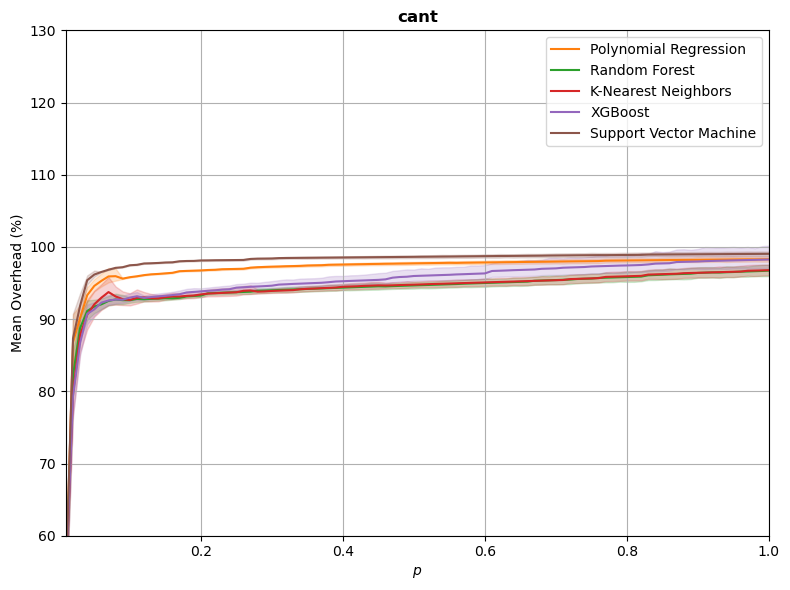

In [26]:
palette = sns.color_palette("tab10", 6)[1:]
for i, (name, model_df) in enumerate(dfs.items()):
    sns.lineplot(model_df, x="p", y="overhead", c=palette[i], label=name)


def formatter(x, pos):
    del pos
    return str(round(x * 100))


plt.gca().yaxis.set_major_formatter(formatter)
plt.gcf().set_size_inches(8, 6)
plt.gcf().set_dpi(100)

plt.xlabel("$p$")
plt.ylabel("Mean Overhead (%)")
plt.title(f"{matrix}", weight="bold")
plt.legend()
plt.grid()
plt.xlim(0.01, 1)
plt.ylim(*ylims[matrix])
plt.tight_layout()
plt.savefig(f"./figures/{matrix}/model_overhead_comparison.png")
plt.show()